In [1]:
import sys
!{sys.executable} -m pip install -q wandb transformers accelerate datasets ftfy scikit-learn torch torchvision pillow seaborn matplotlib tqdm ipywidgets

In [2]:
# Imports dan konfigurasi
import os, math, random, json
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from torchvision import transforms

from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
# from google.colab import drive
# drive.mount('/content/drive')

class Config:
    CURRENT_DIR = os.getcwd()
    RESULTS_DIR = "./results"
    # Sesuaikan path dataset di bawah ini sesuai lokasi data Anda
    IMAGES_DIR = "../Dataset/newimages"
    LABELS_CSV = "../Dataset/new_labels.csv"

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH_SIZE = 16
    EPOCHS = 12
    LR_PRETRAIN = 1e-5
    LR_HEAD = 5e-4
    MAX_LEN = 128
    NUM_CLASSES = 2
    IMAGE_SIZE = 224
    SEED = 42
    NUM_WORKERS = 2
    PATIENCE = 3

    FUSION_IMG_DIM = 512
    FUSION_TEXT_DIM = 256

# Reproducibility
torch.manual_seed(Config.SEED)
random.seed(Config.SEED)
np.random.seed(Config.SEED)

#  folder results
os.makedirs(Config.RESULTS_DIR, exist_ok=True)
print('Device:', Config.DEVICE)
print('Results dir:', Config.RESULTS_DIR)
print('CSV path:', Config.LABELS_CSV)
print('Images dir:', Config.IMAGES_DIR)

Device: cpu
Results dir: ./results
CSV path: ../Dataset/new_labels.csv
Images dir: ../Dataset/newimages


In [3]:
# Weights & Biases logging
USE_WANDB = True
WANDB_RUN = None
if USE_WANDB:
    import wandb
    WANDB_RUN = wandb.init(project='Experiment_TA', config={
        'batch_size': Config.BATCH_SIZE,
        'epochs': Config.EPOCHS,
        'lr_pretrain': Config.LR_PRETRAIN,
        'lr_head': Config.LR_HEAD,
        'max_len': Config.MAX_LEN,
        'image_size': Config.IMAGE_SIZE,
        'fusion_img_dim': Config.FUSION_IMG_DIM,
        'fusion_text_dim': Config.FUSION_TEXT_DIM,
        'patience': Config.PATIENCE,
    })
    print('W&B logging enabled')
else:
    print('W&B logging disabled')

wandb: Currently logged in as: elsa-122140135 (itera) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B logging enabled


In [4]:
# Dataset dan collate function dengan augmentasi
class MultiModalDataset(Dataset):
    def __init__(self, df, images_dir, electra_tokenizer, clip_processor, max_len=128, is_train=False):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.electra_tokenizer = electra_tokenizer
        self.clip_processor = clip_processor
        self.max_len = max_len
        self.is_train = is_train

        # Augmentasi untuk training
        if self.is_train:
            self.augmentation = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            ])
        else:
            self.augmentation = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        text = str(row['Teks_Terlihat']) if 'Teks_Terlihat' in row else ''
        label = int(row['Label'])
        fname = row['File_Name']
        img_path = os.path.join(self.images_dir, fname)
        image = Image.open(img_path).convert('RGB')

        # Terapkan augmentasi jika training
        if self.is_train and self.augmentation:
            image = self.augmentation(image)

        clip_inputs = self.clip_processor(images=image, return_tensors='pt')
        pixel_values = clip_inputs['pixel_values'].squeeze(0)

        enc = self.electra_tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        input_ids = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)

        return {
            'pixel_values': pixel_values,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

def collate_batch(batch):
    pixel_values = torch.stack([b['pixel_values'] for b in batch], dim=0)
    input_ids = torch.stack([b['input_ids'] for b in batch], dim=0)
    attention_mask = torch.stack([b['attention_mask'] for b in batch], dim=0)
    labels = torch.stack([b['label'] for b in batch], dim=0)
    return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask, 'label': labels}

In [5]:
#  tokenizer/processor untuk CLIP dan ELECTRA
clip_model_name = 'openai/clip-vit-base-patch32'
electra_model_name = 'sentinet/suicidality'

clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name)

electra_tokenizer = AutoTokenizer.from_pretrained(electra_model_name)
electra_model = AutoModel.from_pretrained(electra_model_name)

print('Loaded CLIP and ELECTRA components')

c:\Users\elsae\miniconda3\envs\tugasakhir\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded CLIP and ELECTRA components


In [6]:
# Data loading: baca CSV, filter label, split train/val
assert os.path.exists(Config.LABELS_CSV), f'CSV tidak ditemukan: {Config.LABELS_CSV}'
assert os.path.isdir(Config.IMAGES_DIR), f'Folder images tidak ditemukan: {Config.IMAGES_DIR}'

labels_df = pd.read_csv(Config.LABELS_CSV)
label_mapping = {'Non Self-harm': 0, 'Self-harm': 1}
if 'Label' not in labels_df.columns or 'File_Name' not in labels_df.columns:
    raise ValueError('CSV harus memiliki kolom: Label, File_Name, dan Teks_Terlihat (opsional)')

labels_df = labels_df[labels_df['Label'].isin(label_mapping.keys())].copy()
labels_df['Label'] = labels_df['Label'].map(label_mapping)
print('Total baris setelah filter:', len(labels_df))
print('Distribusi label:\n', labels_df['Label'].value_counts().sort_index())

train_df, val_df = train_test_split(labels_df, test_size=0.15, random_state=Config.SEED, stratify=labels_df['Label'])
print('Train:', len(train_df), 'Val:', len(val_df))

train_ds = MultiModalDataset(train_df, Config.IMAGES_DIR, electra_tokenizer, clip_processor, max_len=Config.MAX_LEN, is_train=True)
val_ds = MultiModalDataset(val_df, Config.IMAGES_DIR, electra_tokenizer, clip_processor, max_len=Config.MAX_LEN, is_train=False)

train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, collate_fn=collate_batch, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, collate_fn=collate_batch, pin_memory=torch.cuda.is_available())

print('Dataloaders siap')

Total baris setelah filter: 1312
Distribusi label:
 Label
0    656
1    656
Name: count, dtype: int64
Train: 1115 Val: 197
Dataloaders siap


In [7]:
# Model: CLIP (image + prompt) + ELECTRA (text) -> fusion
class CLIPPromptedElectraFusion(nn.Module):
    def __init__(self, clip_model, electra_model, fusion_img_dim=512, fusion_text_dim=256, num_classes=2, prompt_templates=None, freeze_encoders=True):
        super().__init__()
        self.clip = clip_model
        self.electra = electra_model

        if freeze_encoders:
            for p in self.clip.parameters(): p.requires_grad = False
            for p in self.electra.parameters(): p.requires_grad = False

        self.project_image = nn.Linear(512, fusion_img_dim)
        self.project_prompt = nn.Linear(512, fusion_img_dim)
        self.project_text = nn.Sequential(
            nn.Linear(768, fusion_text_dim),
            nn.GELU(),
            nn.LayerNorm(fusion_text_dim)
        )
        fusion_dim = fusion_img_dim + fusion_text_dim
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim//2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(fusion_dim//2, num_classes)
        )

        self.prompt_templates = prompt_templates if prompt_templates is not None else [
            'a photo of {}.', 'a picture of {}.', 'an image of {}.'
        ]
        self.prompt_alpha = 0.7

    def encode_prompt(self, label_text, device=None):
        prompts = [t.format(label_text) for t in self.prompt_templates]
        inputs = clip_processor(text=prompts, return_tensors='pt', padding=True)
        device = device or next(self.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            txt_feats = self.clip.get_text_features(**inputs)
        txt_feats = txt_feats / (txt_feats.norm(dim=-1, keepdim=True) + 1e-10)
        prompt_emb = txt_feats.mean(dim=0, keepdim=True)
        prompt_emb = prompt_emb / (prompt_emb.norm(dim=-1, keepdim=True) + 1e-10)
        return prompt_emb

    def forward(self, pixel_values, input_ids, attention_mask, prompt_label='self-harm'):
        device = pixel_values.device
        img_feats = self.clip.get_image_features(pixel_values)
        img_feats = img_feats / (img_feats.norm(dim=-1, keepdim=True) + 1e-10)
        img_proj = self.project_image(img_feats)

        prompt_emb = self.encode_prompt(prompt_label, device=device)
        prompt_proj = self.project_prompt(prompt_emb).repeat(img_proj.size(0), 1)
        img_cond = img_proj + self.prompt_alpha * prompt_proj

        txt_out = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = txt_out.last_hidden_state
        attn = attention_mask.unsqueeze(-1).float()
        sum_emb = (last_hidden * attn).sum(dim=1)
        sum_mask = attn.sum(dim=1).clamp(min=1e-9)
        text_emb = sum_emb / sum_mask
        text_proj = self.project_text(text_emb)

        fused = torch.cat([img_cond, text_proj], dim=-1)
        logits = self.classifier(fused)
        return logits, img_proj, text_proj

In [8]:
# Inisialisasi model, optimizer, scheduler, loss, early stopping, history
model = CLIPPromptedElectraFusion(clip_model=clip_model, electra_model=electra_model, fusion_img_dim=Config.FUSION_IMG_DIM, fusion_text_dim=Config.FUSION_TEXT_DIM, num_classes=Config.NUM_CLASSES, freeze_encoders=True)
model = model.to(Config.DEVICE)

pretrained_params = [p for n,p in model.named_parameters() if ('clip' in n or 'electra' in n) and p.requires_grad]
head_params = [p for n,p in model.named_parameters() if ('clip' not in n and 'electra' not in n) and p.requires_grad]

optimizer = torch.optim.AdamW([
    {'params': pretrained_params, 'lr': Config.LR_PRETRAIN},
    {'params': head_params, 'lr': Config.LR_HEAD}
], weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=3, mode='max'):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.num_bad = 0
        self.should_stop = False
    def step(self, value):
        if self.best is None:
            self.best = value
            self.num_bad = 0
            return True
        improve = (value > self.best) if self.mode == 'max' else (value < self.best)
        if improve:
            self.best = value
            self.num_bad = 0
            return True
        else:
            self.num_bad += 1
            if self.num_bad >= self.patience:
                self.should_stop = True
            return False

early_stopper = EarlyStopping(patience=Config.PATIENCE, mode='max')

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'lrs': []
}
# Simpan best model ke RESULTS_DIR
best_model_path = os.path.join(Config.RESULTS_DIR, 'best_multimodal.pth')
print('Model siap. Best model path:', best_model_path)

Model siap. Best model path: ./results\best_multimodal.pth


In [9]:
# function hitung jumlah parameter
def count_parameters(model):
    """Menghitung jumlah parameter dalam model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {frozen_params:,}")
    print(f"Trainable percentage: {100 * trainable_params / total_params:.2f}%")

    return total_params, trainable_params, frozen_params

In [10]:
# Cek parameter keseluruhan model
print("\n Total Model Parameters")
count_parameters(model)

# Cek parameter per komponen
print("\n CLIP Vision Encoder ")
count_parameters(model.clip.vision_model)

print("\n ELECTRA ")
count_parameters(model.electra)

print("\n Projection & Classifier Layers ")
projection_params = sum(p.numel() for p in model.project_image.parameters()) + \
                    sum(p.numel() for p in model.project_prompt.parameters()) + \
                    sum(p.numel() for p in model.project_text.parameters()) + \
                    sum(p.numel() for p in model.classifier.parameters())
print(f"Total parameters: {projection_params:,}")


 Total Model Parameters
Total parameters: 261,187,715
Trainable parameters: 1,018,754
Frozen parameters: 260,168,961
Trainable percentage: 0.39%

 CLIP Vision Encoder 
Total parameters: 87,456,000
Trainable parameters: 0
Frozen parameters: 87,456,000
Trainable percentage: 0.00%

 ELECTRA 
Total parameters: 108,891,648
Trainable parameters: 0
Frozen parameters: 108,891,648
Trainable percentage: 0.00%

 Projection & Classifier Layers 
Total parameters: 1,018,754


In [11]:
# Fungsi train dan evaluasi
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    preds, trues = [], []
    for batch in tqdm(loader):
        optimizer.zero_grad()
        pixel = batch['pixel_values'].to(device)
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        logits, _, _ = model(pixel, ids, mask, prompt_label='self-harm')
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds.extend(logits.argmax(-1).detach().cpu().tolist())
        trues.extend(labels.detach().cpu().tolist())
    acc = accuracy_score(trues, preds)
    return total_loss/len(loader), acc

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    preds, trues = [], []
    for batch in tqdm(loader):
        pixel = batch['pixel_values'].to(device)
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        logits, _, _ = model(pixel, ids, mask, prompt_label='self-harm')
        loss = criterion(logits, labels)
        total_loss += loss.item()
        preds.extend(logits.argmax(-1).detach().cpu().tolist())
        trues.extend(labels.detach().cpu().tolist())
    acc = accuracy_score(trues, preds)
    p, r, f1, _ = precision_recall_fscore_support(trues, preds, average='binary', zero_division=0)
    cm = confusion_matrix(trues, preds)
    return total_loss/len(loader), acc, p, r, f1, cm, preds, trues

In [ ]:
# Main training loop dengan early stopping, scheduler, dan  W&B
best_f1 = -1
for epoch in range(1, Config.EPOCHS+1):
    print(f' Epoch {epoch}/{Config.EPOCHS} ')
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, Config.DEVICE)
    val_loss, val_acc, p, r, f1, cm, val_preds, val_trues = evaluate(model, val_loader, Config.DEVICE)
    scheduler.step(val_loss)

    # Catat LR (group pertama) setelah scheduler step
    current_lr = optimizer.param_groups[0]['lr']
    history['lrs'].append(current_lr)
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)

    print(f'Train loss {train_loss:.4f} acc {train_acc:.4f}')
    print(f'Val   loss {val_loss:.4f} acc {val_acc:.4f} p {p:.4f} r {r:.4f} f1 {f1:.4f} lr {current_lr:.2e}')
    print('Confusion matrix:\n', cm)

    if USE_WANDB:
        import wandb
        wandb.log({'epoch': epoch, 'train/loss': train_loss, 'train/acc': train_acc, 'val/loss': val_loss, 'val/acc': val_acc, 'val/precision': p, 'val/recall': r, 'val/f1': f1, 'lr': current_lr})

    improved = early_stopper.step(f1)
    if improved:
        best_f1 = f1
        torch.save(model.state_dict(), best_model_path)
        print('Best model disimpan (F1 meningkat).')
    else:
        print(f'Tidak ada peningkatan F1 ({early_stopper.num_bad}/{Config.PATIENCE}).')

    if early_stopper.should_stop:
        print('Early stopping tercapai.')
        break

print('Training selesai. Best F1:', best_f1)

 Epoch 1/12 


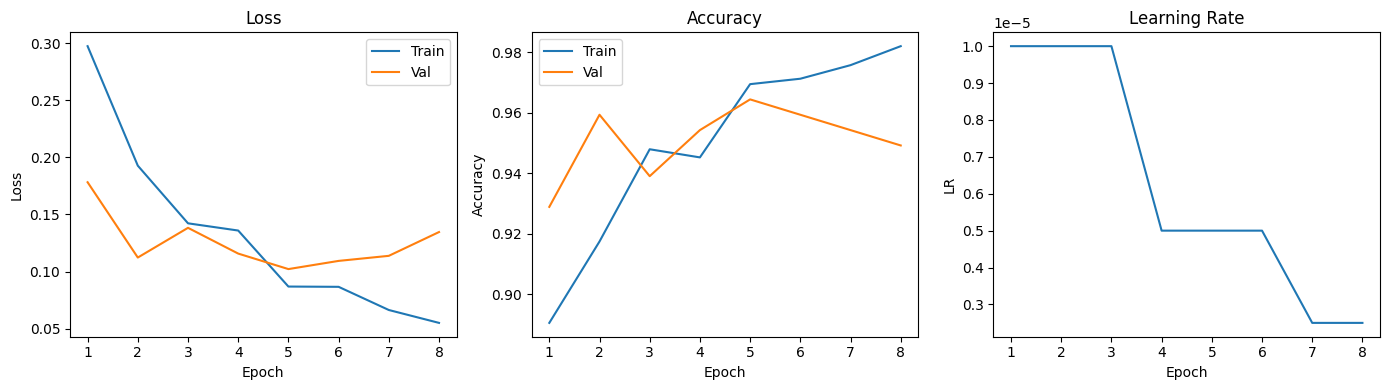

In [ ]:
# Plot history: Loss, Accuracy, dan Learning Rate
epochs = range(1, len(history['train_loss'])+1)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(epochs, history['train_loss'], label='Train')
plt.plot(epochs, history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, history['train_acc'], label='Train')
plt.plot(epochs, history['val_acc'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, history['lrs'], label='LR')
plt.title('Learning Rate')
plt.xlabel('Epoch'); plt.ylabel('LR')
plt.tight_layout()
plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

VAL -> loss 0.1021 acc 0.9645 p 0.9789 r 0.9490 f1 0.9637
Classification Report:
               precision    recall  f1-score   support

Non Self-harm       0.95      0.98      0.97        99
    Self-harm       0.98      0.95      0.96        98

     accuracy                           0.96       197
    macro avg       0.96      0.96      0.96       197
 weighted avg       0.96      0.96      0.96       197



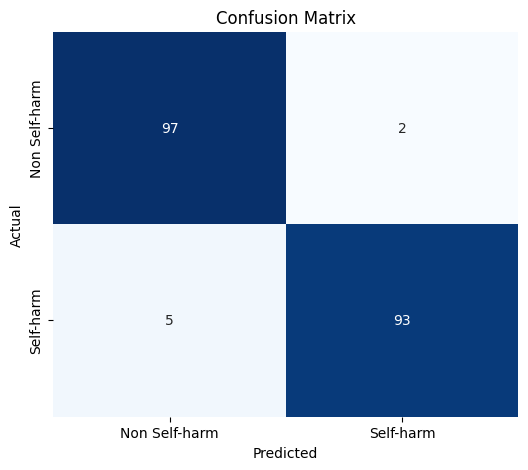

In [ ]:
# Muat best model, evaluasi lengkap (accuracy/precision/recall/F1), classification report, confusion matrix plot
assert os.path.exists(best_model_path), 'Best model belum tersimpan. Jalankan training terlebih dahulu.'
model.load_state_dict(torch.load(best_model_path, map_location=Config.DEVICE))
model.to(Config.DEVICE); model.eval()

val_loss, val_acc, p, r, f1, cm, preds, trues = evaluate(model, val_loader, Config.DEVICE)
print(f'VAL -> loss {val_loss:.4f} acc {val_acc:.4f} p {p:.4f} r {r:.4f} f1 {f1:.4f}')

target_names = ['Non Self-harm', 'Self-harm']
print('Classification Report:')
print(classification_report(trues, preds, target_names=target_names, zero_division=0))

cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Wrap-up: akhiri W&B run jika digunakan
if USE_WANDB and WANDB_RUN is not None:
    import wandb
    wandb.finish()
    print('W&B run finished.')
else:
    print('W&B tidak digunakan.')

epoch,▁▂▃▄▅▆▇█
lr,███▃▃▃▁▁
train/acc,▁▃▅▅▇▇██
train/loss,█▅▄▃▂▂▁▁
val/acc,▁▇▃▆█▇▆▅
val/f1,▁▇▃▆█▇▆▅
val/loss,█▂▄▂▁▂▂▄
val/precision,█▁██▅▅▄▁
val/recall,▁█▃▅█▇▆▆
epoch,8
lr,0.0


W&B run finished.
